# Fitbit analysis

## Download Fitbit data
Export your Fitbit data for the lifetime of your account by following the instructions at [Export Your Account Archive](https://www.fitbit.com/settings/data/export)

```bash
cd MyFitbitData
unzip MyFitbitData.zip
```

This file should contain all your personal Fitbit data. Mine for example had 7,921 files once I unzipped the 79MB file.

## Notebook for Fitbit data analysis with DuckDB
Expected to be run in a notebook, DuckDB’s Python client can be used [directly in Jupyter notebook](https://duckdb.org/docs/guides/python/jupyter)

First step is import the relevant librariesSet and configure to directly output data to Pandas and to simplify the output that is printed to the notebook.



In [1]:
import duckdb
import pandas as pd
import seaborn as sns

%load_ext sql
%sql duckdb:///:memory:

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

### JSON DuckDB extension

Load [JSON DuckDB extension](https://duckdb.org/docs/extensions/json) is a loadable extension that implements SQL functions that are useful for reading values from existing JSON, and creating new JSON data.

In [2]:
%%sql
INSTALL json;
LOAD json;

""


## AttributeError: 'duckdb.DuckDBPyConnection'
If the loading the JSON DuckDB extension gave the error `AttributeError: 'duckdb.DuckDBPyConnection' object has no attribute 'dialect'` try downgrading `jupysql` with the following command and restart your Jupyter notebook kernal. 

You can ignore this step if the JSON DuckDB extension loaded OK.

In [ ]:
pip install --force-reinstall  "jupysql==0.7.4"

## Activity data

Physical Activity and broad exercise information appears to be stored in numbered files such as `Physical Activity/exercise-1700.json`

I couldn't work out what the file-numbers actually meant, I guess they are just increasing integers for a collection of exercise files. In my case the earliest files started at 0 and went to 1700.

Inside is an array of records, each with a description of an activity. The record seems to change depending on the activity - here is an example of a "walk"

```json
  "activityName" : "Walk",
  "averageHeartRate" : 79,
  "calories" : 122,
  "duration" : 1280000,
  "steps" : 1548,
  "startTime" : "01/06/23 01:08:57",
  "elevationGain" : 67.056,
  "hasGps" : false,
  : : : :
  "activityLevel" : [
    { "minutes" : 1, "name" : "sedentary"},
    { "minutes" : 2, "name" : "lightly"},
    { "minutes" : 6, "name" : "fairly"},
    { "minutes" : 6, "name" : "very"
  }]
```

To load all of the exercise files into the the `physical_activity` table

In [23]:
%%sql

CREATE OR REPLACE TABLE physical_activity
as
SELECT 
  startTime + INTERVAL 11 hours as activityTime
, activityName
, activityLevel
, averageHeartRate
, calories
, duration / 60000 as duration_minutes
, steps
, distance
, distanceUnit
, tcxLink
, source
FROM read_json('MyFitbitData/SimonAubury/Physical Activity/exercise-*.json'
, columns={startTime: 'TIMESTAMP', activityName: 'VARCHAR',  activityLevel: 'JSON', averageHeartRate: 'INTEGER', calories: 'INTEGER', duration: 'INTEGER', steps: 'INTEGER', tcxLink: 'VARCHAR', distance: 'DOUBLE', distanceUnit: 'VARCHAR', source: 'JSON'}
, format='array'
, timestampformat='%m/%d/%y %H:%M:%S');

,Count
0,1972


## Different Fitbit devices
I've actually had two Fitbit devices and have used Strava too as a data source for my Fitbit data - I can review the number of activities collected from each source device.

In [24]:
%%sql
select json_extract(source, '$.name') as source_name
, min(activityTime) as activity_from
, max(activityTime) as activity_to
, count(*) as num_activities
from physical_activity
where source is not null
group by 1
order by 2

,source_name,activity_from,activity_to,num_activities
0,"""Surge""",2018-07-13 08:29:01,2021-04-20 07:24:12,355
1,"""Versa 3""",2021-04-21 19:53:17,2023-05-23 07:37:15,419
2,"""Official Strava""",2022-10-04 09:09:36,2022-10-04 09:09:36,1


### Load Physical Activity data into data frame
Load Physical Activity data into data frame. We can use the [time_bucket](https://duckdb.org/docs/sql/functions/timestamp.html) DuckDB function to truncate the _activityTime_ timestamp into monthly buckets.

In [25]:
%%sql
activity_df <<
  select cast(time_bucket(interval '1 month', activityTime	) as DATE) as activity_day
  , activityName
  , sum(duration_minutes) as duration
  from physical_activity
  where activityTime between '2022-11-01' and '2023-05-31'
  group by 1, 2
  order by 1;

### Plot Monthly Activity Minutes
We can not take the monthly activity minutes of activity and produce a bar plot of activity.

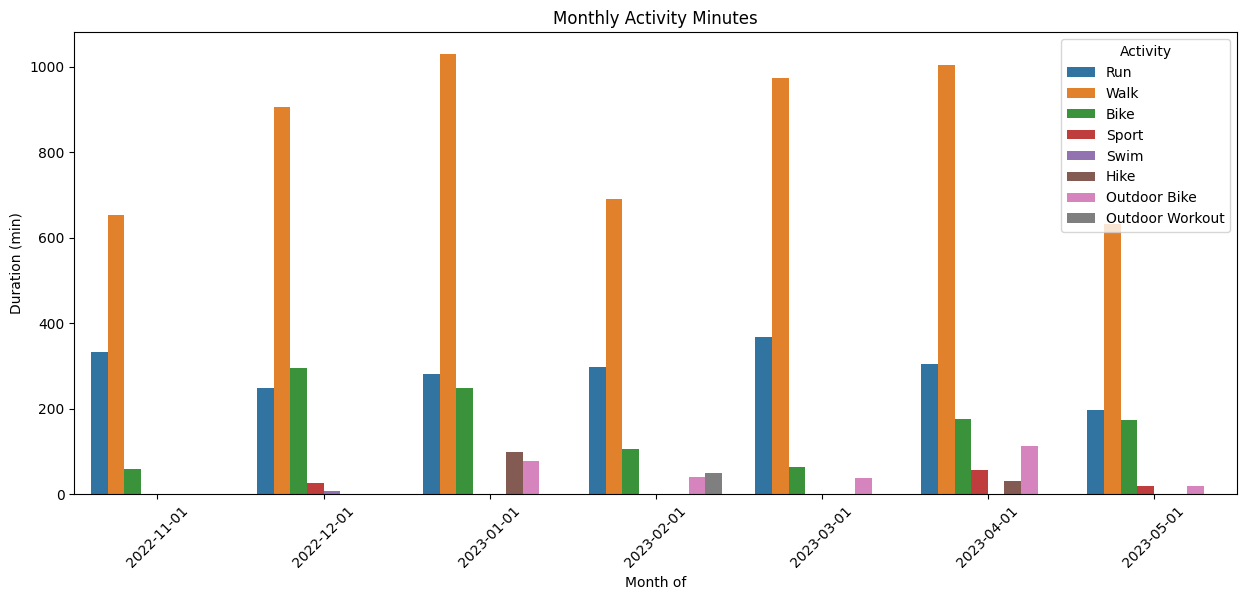

In [26]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
plt.figure(figsize=(15, 6))
plt.xticks(rotation=45)

myplot =sns.barplot(data=activity_df, x="activity_day", y="duration", hue="activityName")
myplot.set(xlabel='Month of', ylabel='Duration (min)', title='Monthly Activity Minutes')
plt.legend(loc="upper right", title='Activity') 
plt.show()


# Sleep

Sleep data appears in dated files like `Sleep/sleep-2022-12-28.json`. It appears that each file hold a months worth of daata, but dated the month before the event? File `sleep-2022-12-28.json` seems to have data for 2023-01-02 to 2023-01-27?

Within the record is an extended "levels" block with a breakdown of sleep type (wake, light, REM, deep)

```json
  "logId" : 39958970367,
  "startTime" : "2023-01-26T22:47:30.000",
  "duration" : 26040000,
  :: :: ::
  "levels": 
    "summary" : {
      {
      "light": { "count": 30, "minutes": 275},
      "rem": { "count": 4, "minutes": 48 },
      "wake": { "count" : 29, "minutes" : 42 },
      "deep" : { "count" : 12, "minutes" : 75}
      }
    }
```

Whereas older files look like this, with a differnt breakdown of sleep type (restless, awake, asleep)

```json
  "logId" : 18841054316,
  "startTime" : "2018-07-12T22:42:00.000",
  "duration" : 25440000,
  :: :: ::
  "levels" : {
    "summary" : {
      "restless" : {"count" : 9, "minutes" : 20 },
      "awake" : { "count" : 2, "minutes" : 5 },
      "asleep" : { "count" : 0,   "minutes" : 399}
    }
  }
```

We can use the [DuckDB JSON](https://duckdb.org/docs/extensions/json.html) reader to read the records into a table

In [27]:
%%sql

CREATE OR REPLACE TABLE sleep_log
as
select dateOfSleep	
, levels
from read_json('MyFitbitData/SimonAubury/Sleep/sleep*.json'
, columns={dateOfSleep: 'DATE', levels: 'JSON'}
, format='array') ;

,Count
0,1000


## Schema changes for sleep data

There appears to be a schema change in the way sleep is recorded (most likly as I changed models of fitbit devices). Some of the records have time recorded against `$.awake` which is similar (but not identical to) `$.wake`

I decided I could use the SQL [coalesce](https://duckdb.org/docs/sql/functions/utility.html) function - which return the first expression that evaluates to a non-NULL value.

In [28]:
%%sql
sleep_log_df <<
    select dateOfSleep
    , cast(coalesce(json_extract(levels, '$.summary.awake.minutes'), json_extract(levels, '$.summary.wake.minutes')) as int) as min_wake
    , cast(coalesce(json_extract(levels, '$.summary.deep.minutes'), json_extract(levels, '$.summary.asleep.minutes')) as int) as min_deep
    , cast(coalesce(json_extract(levels, '$.summary.light.minutes'), json_extract(levels, '$.summary.restless.minutes')) as int) as min_light
    , cast(coalesce(json_extract(levels, '$.summary.rem.minutes'), 0) as int) as min_rem
    from sleep_log
    where dateOfSleep between '2023-03-01' and '2023-03-30'
    order by 1

### Plot sleep activity
We can not take the daily sleep logs and produce a stacked bar plot showing the breakdown each night of being awake and in light, deep and [REM](https://en.wikipedia.org/wiki/Rapid_eye_movement_sleep) sleep.

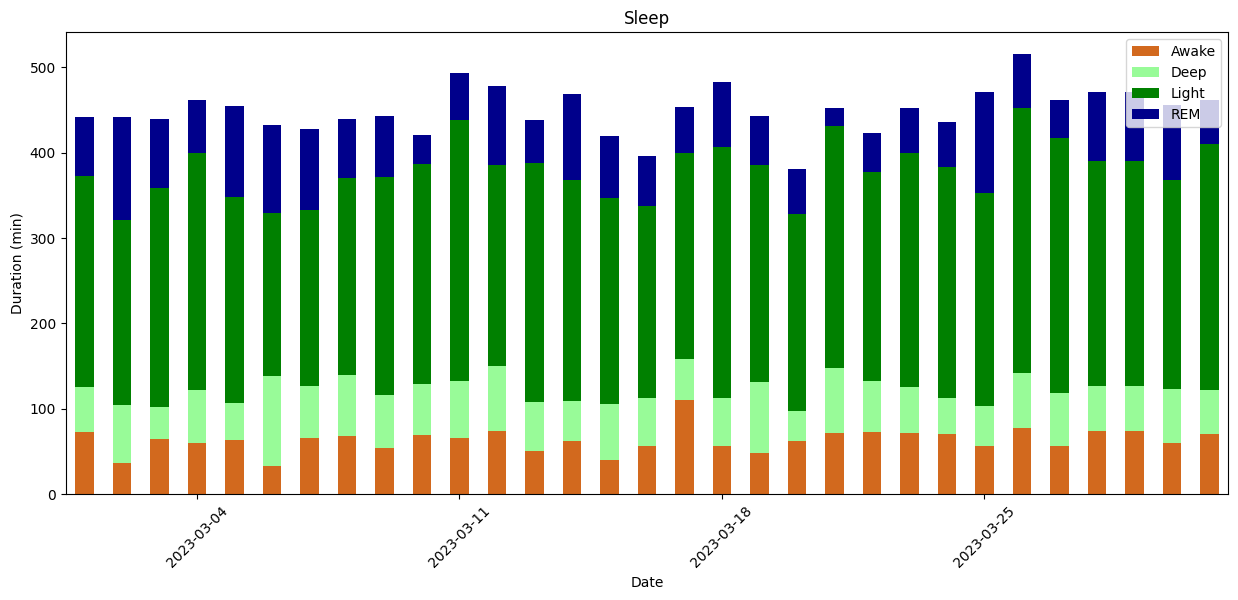

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

#create stacked bar chart
fig, axes = plt.subplots(figsize=(15,6))
myplot = sleep_log_df.set_index('dateOfSleep').plot(ax=axes, kind='bar', stacked=True, color=['chocolate', 'palegreen', 'green', 'darkblue'])
myplot.set(xlabel='Date', ylabel='Duration (min)', title='Sleep')

axes.xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.legend(loc="upper right", labels = ['Awake', 'Deep', 'Light', 'REM']) 
plt.xticks(rotation=45)
plt.show()

# Heart rate

Heart rate is captured very frequenelty (every 10-15 seconds) in files stored daily named like `Physical Activity/heart_rate-2023-01-26.json`. 

These files are really bit - each day has around 70,000 lines - all wrapped in a single array

```json
[{{"dateTime": "01/25/25 13:00:07", "value": {"bpm": 54, "confidence": 2}},
  {"dateTime": "01/25/25 13:00:22", "value": {"bpm": 54, "confidence": 2}},
  {"dateTime": "01/25/25 13:00:37", "value": {"bpm": 55, "confidence": 2}},
  : : : : : :
  {"dateTime": "01/26/26 12:59:57", "value": {"bpm": 55, "confidence": 3}
}]
```

I think the file name represents the locale of the user. For example, in my timezone (GMT+11) named `heart_rate-2023-01-26.json` I think covers the day 26 00:00 (AEST) to 23:59 (AEST) - and it makes logical sense if the dates within the files are in GMT.

### Transform JSON files

I found I was unable to process the very large array_of_records JSON files. Observed this error on large array_of_records JSON files

__(duckdb.InvalidInputException)  "INTERNAL Error: Unexpected yyjson tag in ValTypeToString"__

The fix was to change the file so it wasn't an array of JSON records, instead I wanted newline-delimited JSON, or  [ndjson](http://ndjson.org/). 
So, instead of an array with 70,000 records, I now have a file with 70,000 lines, with each JSON record now stored on a new line. 

```json
{"dateTime": "01/25/23 13:00:07", "value": {"bpm": 54, "confidence": 2}
{"dateTime": "01/25/23 13:00:22", "value": {"bpm": 54, "confidence": 2}
{"dateTime": "01/25/23 13:00:37", "value": {"bpm": 55, "confidence": 2}
  : : : : : :
{"dateTime": "01/26/23 12:59:57", "value": {"bpm": 55, "confidence": 3}
```

To transform Heart rate array_of_records --> records (ndjson Newline Delimited JSON)

In [ ]:
import glob
import json
import ndjson
import re

for json_src_file in sorted(glob.glob('MyFitbitData/SimonAubury/Physical Activity/steps-*.json') + glob.glob('MyFitbitData/SimonAubury/Physical Activity/heart_rate-*.json')):
  json_dst_file = re.sub('\.[a-z]*$', '.ndjson', json_src_file)
  print(f'{json_src_file} -->  {json_dst_file}')

  with open(json_src_file) as f_json_src_file:
    json_dict =json.load(f_json_src_file) 

    with open(json_dst_file, 'w') as outfile:
      ndjson.dump(json_dict, outfile)


### Load heart rate data into table
Load heart rate data into table

Note the use of `timestampformat='%m/%d/%y %H:%M:%S');` to describe the leading month in the dates (for example _"01/25/23 13:00:07"_)

In [30]:
%%sql

CREATE OR REPLACE TABLE heart_rate
as
SELECT dateTime + INTERVAL 11 hours as hr_date_time
, cast(value->'$.bpm' as integer) as bpm
FROM read_json('MyFitbitData/SimonAubury/Physical Activity/*.ndjson'
, columns={dateTime: 'TIMESTAMP', value: 'JSON'}
, format='newline_delimited'
, timestampformat='%m/%d/%y %H:%M:%S');

,Count
0,12891781


### Load heart rate into data frame
Load a single days worth of data into a data frame

In [31]:
%%sql
hr_df << 
    SELECT time_bucket(interval '1 minutes', hr_date_time	) as created_day
    ,  min(bpm) as bpm_min
    ,  avg(bpm) as bpm_avg
    ,  max(bpm) as bpm_max
    FROM heart_rate
    where hr_date_time between '2023-05-21 00:00' and '2023-05-21 23:59'
    group by 1;

### Plot Heart rate
I can plat the heart rate using a plot like this (and also to show off I actually did go for a run at 6am)

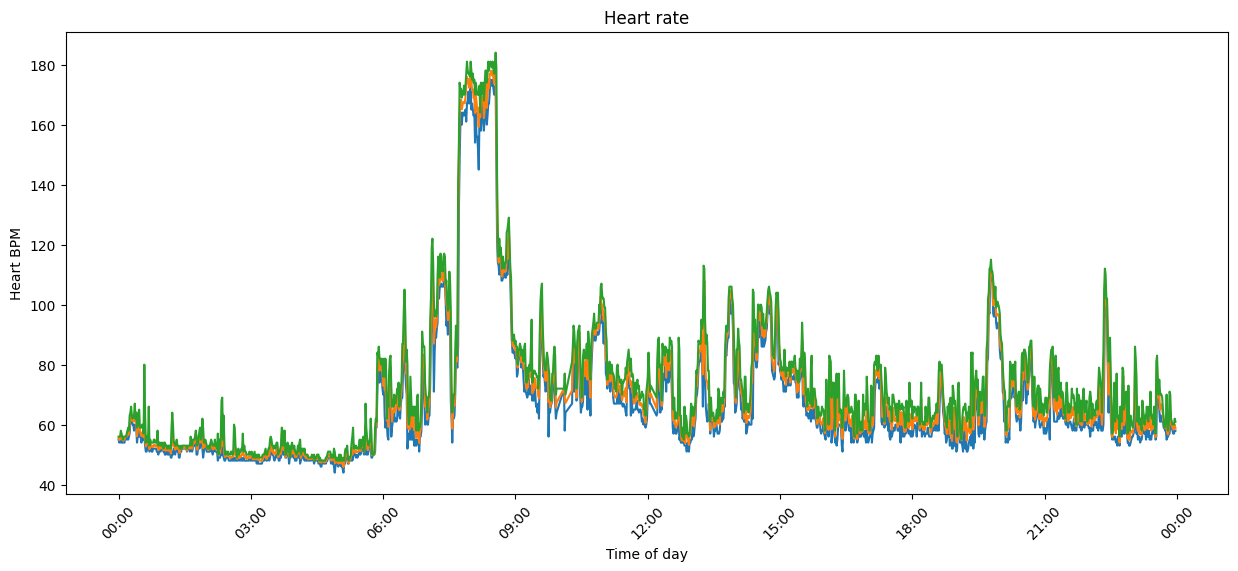

In [32]:

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
plt.figure(figsize=(15, 6))
plt.xticks(rotation=45)

myplot = sns.lineplot(data=hr_df, x="created_day", y="bpm_min")
myplot = sns.lineplot(data=hr_df, x="created_day", y="bpm_avg")
myplot = sns.lineplot(data=hr_df, x="created_day", y="bpm_max")

myFmt = DateFormatter("%H:%M")
myplot.xaxis.set_major_formatter(myFmt)
myplot.set(xlabel='Time of day', ylabel='Heart BPM', title='Heart rate')
plt.show()

# Steps

Steps are recored in daily files named `Physical Activity/steps-2023-02-26.json`. This appears to be a fine grain count of steps during period blocks (every 5 to 10 minutes) throughtout the day


```json
[{
  "dateTime" : "02/25/23 13:17:00",
  "value" : "0"
},{
  "dateTime" : "02/25/23 13:52:00",
  "value" : "5"
},{
  "dateTime" : "02/25/23 14:00:00",
  "value" : "0"
},{

:: :: ::
},{
  "dateTime" : "03/24/23 08:45:00",
  "value" : "15"
}]
```

To aggregate the steps into daily counts I needed to convert GMT into my local timezone (GMT+11)

In [33]:
%%sql
steps_df <<
select cast(time_bucket(interval '1 day', dateTime + INTERVAL 11 hours	) as DATE) as activity_day
, sum(value) as steps
from read_json('MyFitbitData/SimonAubury/Physical Activity/steps-2023-02-26.ndjson'
, auto_detect=True
, format='newline_delimited'
, timestampformat='%m/%d/%y %H:%M:%S') 
group by 1;

### Plot daily steps
We can not take dataframe and plot a daily step count

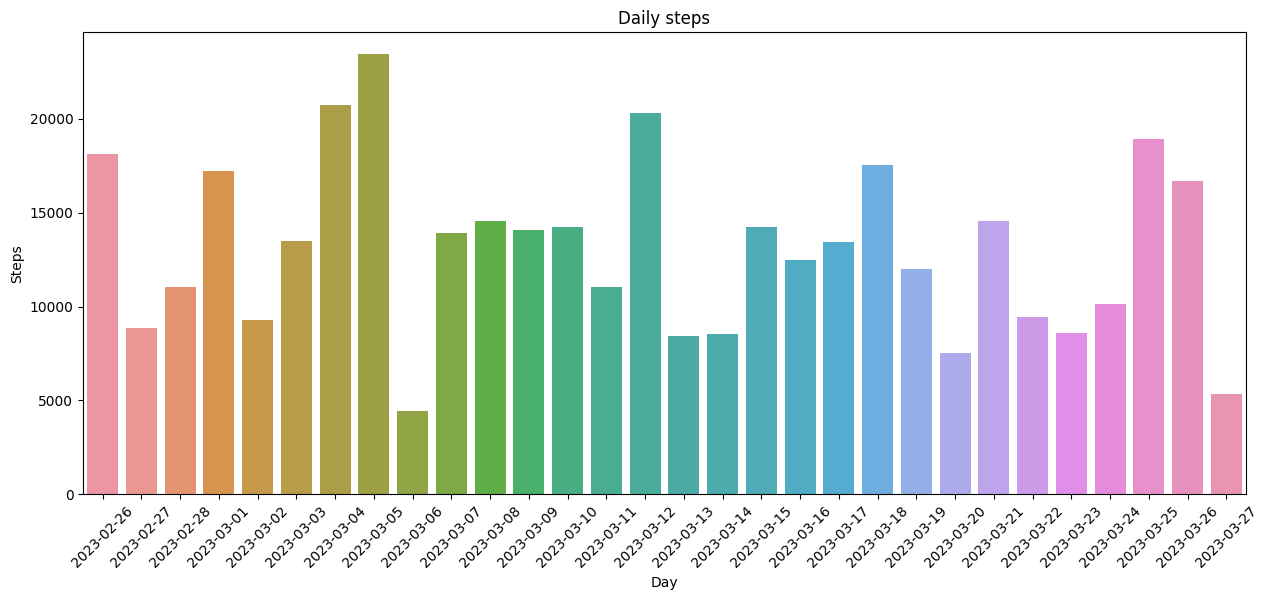

In [34]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
plt.figure(figsize=(15, 6))
plt.xticks(rotation=45)

myplot = sns.barplot(data=steps_df, x="activity_day", y="steps")
myplot.set(xlabel='Day', ylabel='Steps', title='Daily steps')
plt.show()

## GEO

Fitbit appears to store  GPS logged activities as [TCX (Training Center XML)](https://en.wikipedia.org/wiki/GPS_Exchange_Format) files. These XML files are _not_ in the downloaded ZIP, but we have a refernce to their location in the Physical Activity files

```json
  "logId" : 53025679511,
  "activityName" : "Run",
  "activityTypeId" : 90009,
  :: :: ::
  "tcxLink" : "https://www.fitbit.com/activities/exercise/53025679511?export=tcx",
```

In [ ]:
%%sql
select tcxLink 
from physical_activity
where tcxLink is not null
limit 5;


#### TCX - GPS XML files

Looking inside the TCX file, we find low level GPS locations every few seconds 


```xml
<TrainingCenterDatabase>
    <Activities>
        <Activity Sport="Running">
            <Id>2023-04-11T06:26:09.000+10:00</Id>
            <Lap StartTime="2023-04-11T06:26:09.000+10:00">
                <Track>
                    <Trackpoint>
                        <Time>2023-04-11T06:26:09.000+10:00</Time>
                        <Position>
                            <LatitudeDegrees>-35.280324935913086</LatitudeDegrees>
                            <LongitudeDegrees>149.12922656536102</LongitudeDegrees>
                        </Position>
                        <AltitudeMeters>72.04199999536705</AltitudeMeters>
                        <DistanceMeters>0.0</DistanceMeters>
                        <HeartRateBpm>
                            <Value>112</Value>
                        </HeartRateBpm>
                    </Trackpoint>
```

We can convert these XML files into JSON files like this

In [ ]:
import glob
import json
import ndjson
import xmltodict
import re

for xml_src_file in sorted(glob.glob('MyFitbitData/tcx/*.tcx')):
    json_dst_file = re.sub('\.[a-z]*$', '.ndjson', xml_src_file)
    print(f'{xml_src_file} -->  {json_dst_file}')

    with open(xml_src_file) as f_xml_src_file:
        # erase file if it exists
        open(json_dst_file, 'w') 
        data_dict = xmltodict.parse(f_xml_src_file.read())

        # Loop over the "laps" in the file; roughly every 1km
        for lap in data_dict['TrainingCenterDatabase']['Activities']['Activity']['Lap']:
            data_dict_inner = lap['Track']['Trackpoint']
            # append file
            with open(json_dst_file, 'a') as outfile:
                ndjson.dump(data_dict_inner, outfile)
                outfile.write('\n')

#### Loading GPS Geospatial data
We can load the Geospatial data like this

In [35]:
%%sql
route_df <<
    SELECT time
    , position
    , cast(json_extract_string(position, '$.LatitudeDegrees') as float) as latitude
    , cast(json_extract_string(position, '$.LongitudeDegrees') as float) as longitude
    FROM read_json('MyFitbitData/tcx/54939192717.ndjson'
    , columns={Time: 'TIMESTAMP', Position: 'JSON', AltitudeMeters: 'FLOAT', DistanceMeters: 'FLOAT', HeartRateBpm: 'JSON'}
    , format='newline_delimited'
    , timestampformat='%Y-%m-%dT%H:%M:%S.%f%z');


### Visualize GPS Routes with Folium


I used this blog to help [Visualize routes with Folium](https://betterdatascience.com/data-science-for-cycling-how-to-visualize-gpx-strava-routes-with-python-and-folium/)

In [36]:
import folium

route_map = folium.Map(
    location=[-35.275, 149.129],
    zoom_start=13,
    tiles='openstreetmap',
    width=1024,
    height=600
)

coordinates = [tuple(x) for x in route_df[['latitude', 'longitude']].to_numpy()]
folium.PolyLine(coordinates, weight=8, color='red').add_to(route_map)

display(route_map)